## Predicts multiple regression scalars as probs (still classification)

In [19]:
from fastai.vision.all import *

In [20]:

from fastcore.basics import Int
from fastcore.transform import DisplayedTransform
from fastcore.xtras import Path

from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import fine_tune

from fastai.data.block import DataBlock, RegressionBlock
from fastai.data.transforms import RandomSplitter, get_image_files, ColReader

from fastai.losses import MSELossFlat

from fastai.torch_core import ShowTitle, show_title, TitledFloat

from fastai.vision.augment import Resize, aug_transforms, Flip, Rotate, Zoom, Warp
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models.resnet import resnet50

from datetime import datetime, timedelta


import pandas as pd
from scipy.io import loadmat
import numpy as np

from scipy.io import loadmat
from datetime import datetime, timedelta

from fastai.metrics import mae, rmse, R2Score


In [33]:

n_out_val      = 4
img_resize_val = 150


In [22]:

path= 'plant/'


In [23]:

train = pd.read_csv(path +'train.csv')


In [24]:
train

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


We need to create a tuple is (x,y) for our model to train. So we'll create like this (image_id, [healthy multiple_diseases rust scab])Let's create a new column combined which is a list of the dependent variables

In [25]:

train['combined'] = train[ ['healthy','multiple_diseases','rust','scab'] ].values.tolist()


In [26]:
train

,image_id,healthy,multiple_diseases,rust,scab,combined
0,Train_0,0,0,0,1,"[0, 0, 0, 1]"
1,Train_1,0,1,0,0,"[0, 1, 0, 0]"
2,Train_2,1,0,0,0,"[1, 0, 0, 0]"
3,Train_3,0,0,1,0,"[0, 0, 1, 0]"
4,Train_4,1,0,0,0,"[1, 0, 0, 0]"
...,...,...,...,...,...,...
1816,Train_1816,0,0,0,1,"[0, 0, 0, 1]"
1817,Train_1817,1,0,0,0,"[1, 0, 0, 0]"
1818,Train_1818,1,0,0,0,"[1, 0, 0, 0]"
1819,Train_1819,0,0,1,0,"[0, 0, 1, 0]"


In [27]:

class TitledList(list, ShowTitle):
    _show_args = {'label': 'text'}
    
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(self, ctx=ctx, **merge(self._show_args, kwargs))


In [28]:

## "Transform to int tensor"
## order = 10 #Need to run after PIL transforms on the GPU


class ToListTensor(DisplayedTransform):
    _show_args = {'label': 'text'}
    
    def __init__(self, split_idx=None,):
        super().__init__(split_idx=split_idx)

    def encodes(self, o): return o
    
    def decodes(self, o): return TitledList(o)


In [32]:
blocks = [ ImageBlock, RegressionBlock(n_out=n_out_val)  ]

In [34]:

item_tfms = [  Resize(img_resize_val)  ];    

batch_tfms = [  *aug_transforms( flip_vert=True, size=(128) ), 
                Normalize.from_stats(  *imagenet_stats   )
]

splitter = RandomSplitter()


In [35]:

plant = DataBlock(blocks = blocks,
                  get_x = ColReader('image_id', pref=f'plant/images/', suff='.jpg'),
                  get_y = Pipeline( [ColReader('combined'), ToListTensor ]),
                  splitter = splitter,
                  item_tfms= item_tfms,
                  batch_tfms = batch_tfms,
                  n_inp = 1
)


In [36]:

dls = plant.dataloaders(train)


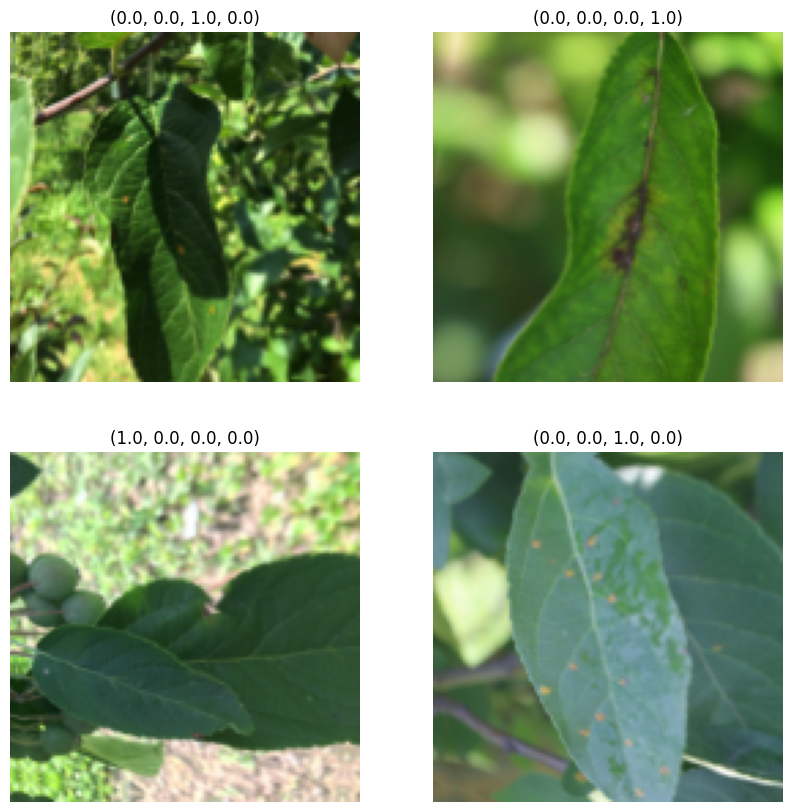

In [37]:


dls.show_batch(nrows=2, ncols=2, figsize=(10,10))


In [38]:
plant.summary(train)

Setting-up type transforms pipelines
0        Train_0        0                  0     0     1  [0, 0, 0, 1]
1        Train_1        0                  1     0     0  [0, 1, 0, 0]
2        Train_2        1                  0     0     0  [1, 0, 0, 0]
3        Train_3        0                  0     1     0  [0, 0, 1, 0]
4        Train_4        1                  0     0     0  [1, 0, 0, 0]
...          ...      ...                ...   ...   ...           ...
1816  Train_1816        0                  0     0     1  [0, 0, 0, 1]
1817  Train_1817        1                  0     0     0  [1, 0, 0, 0]
1818  Train_1818        1                  0     0     0  [1, 0, 0, 0]
1819  Train_1819        0                  0     1     0  [0, 0, 1, 0]
1820  Train_1820        0                  0     0     1  [0, 0, 0, 1]

[1821 rows x 6 columns]
Found 1821 items
2 datasets of sizes 1457,364
Setting up Pipeline: ColReader -- {'cols': 'image_id', 'pref': 'plant/images/', 'suff': '.jpg', 'label_delim': 

In [39]:

dls.c = n_out_val


## Training

In [40]:

model = resnet18


In [43]:

learn = cnn_learner(
               dls, 
               model, 
               metrics = [ MSELossFlat() ], 
               loss_func = L1LossFlat(),
               y_range=(0,1),
)


In [45]:

learn.fine_tune(3)


epoch,train_loss,valid_loss,None,time
0,0.225590,0.192102,0.128825,02:33


epoch,train_loss,valid_loss,None,time
0,0.187812,0.163264,0.109643,03:26
1,0.164452,0.118312,0.074091,03:26
2,0.142911,0.109583,0.067942,03:25


## Inference

In [46]:

test_img = pd.read_csv( path + 'test.csv')


In [47]:
test_img

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4
...,...
1816,Test_1816
1817,Test_1817
1818,Test_1818
1819,Test_1819


In [48]:

dl = learn.dls.test_dl(test_img)


In [49]:

probs, _ = learn.get_preds( dl=dl )

In [50]:

p1 = pd.DataFrame(
           probs, 
           columns=[ ['healthy','multiple_diseases','rust','scab'] ]
)




In [51]:

p1['image_id'] = test_img.image_id

cols = ['image_id','healthy','multiple_diseases','rust','scab']

p1[cols]


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.006250,0.182081,0.830041,0.031402
1,Test_1,0.000010,0.483096,1.000000,0.000232
2,Test_2,0.000216,0.019311,0.000509,1.000000
3,Test_3,1.000000,0.100114,0.001275,0.000140
4,Test_4,0.000031,0.082993,1.000000,0.000334
...,...,...,...,...,...
1816,Test_1816,0.000112,0.760785,1.000000,0.001458
1817,Test_1817,0.427758,0.190348,0.010123,0.981025
1818,Test_1818,0.004893,0.030563,0.756920,0.852979
1819,Test_1819,1.000000,0.185368,0.000126,0.000739
